In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import scipy
from scipy.optimize import curve_fit
from scipy import stats
import seaborn as sns
from sklearn.decomposition import PCA
import random
from statannot import add_stat_annotation
import pandas as pd
from tqdm import tqdm
%matplotlib inline

# Overview

Ok, so this will be the attempt to replicate the very confusingly written PCA analysis done in the Charles River HD paper. The overall goal is to compute the PCA of the empirical data correlation of marker trajectory data. This is also known as the Karkunen-Loeve transform. This is *independent* of kinematic parameters. The data matrix we will be using will have one dimension for each individual step and another dimension for each trajectory concatenated. 

1. 2d marker data of a number of points
2. Temporally normalize by interpolating. For us this might look like: $f(x) + N(\sigma)$ where $f$ is the interpolated function, $\sigma$ is the varience of the trajectory data in that step, and $N$ is normal noise. 
3. Compute data correlation matrix is $X^TX/n$


In [4]:
step_seconds = pd.read_csv('C:\\Users\\aar1105\\Box Sync\\BevanLab\\Projects\\gait\\open_field_gait\\data\\MitoPark_test_data.csv')

In [5]:
step_seconds.head()

,Mouse,Video,Start Time,End Time,Genotype,FPS,Include,h5
0,1057,1057-2,02:49.8,02:50.1,MitoPark,100,True,D:\\MitoPark\\Open Field\\DLC_MP_test\\1057-2-...
1,1057,1057-2,02:50.1,02:50.5,MitoPark,100,True,D:\\MitoPark\\Open Field\\DLC_MP_test\\1057-2-...
2,1057,1057-2,03:31.7,03:31.9,MitoPark,100,True,D:\\MitoPark\\Open Field\\DLC_MP_test\\1057-2-...
3,1057,1057-2,03:31.9,03:32.2,MitoPark,100,True,D:\\MitoPark\\Open Field\\DLC_MP_test\\1057-2-...
4,1057,1057-2,03:32.2,03:32.5,MitoPark,100,True,D:\\MitoPark\\Open Field\\DLC_MP_test\\1057-2-...


In [6]:
DLCscorer = "DLC_resnet152_paw_40_labelsApr2shuffle1_200000"


In [7]:
def get_snippet(data, bodypart, DLCScorer, start_sec, end_sec, fps) -> pd.DataFrame: 
    return data[DLCscorer][bodypart][int(start_sec * fps): int(end_sec * fps)]

def polynomial(x, a,b,c, d, e):
    return a + b*x + c*(x*x) + d * (x * x * x) + e * (x**4)

def convert_time_to_seconds (time: str) -> int:
    
    """
    Takes time in the form MM:SS:ms and converts to seconds
    """
    time = time.split(':')
    out = int(time[0]) * 60 + float(time[1])
    return out

def fit_paw_to_polynomial(paw):
    timedata = np.linspace(0, paw['x'].size, paw['x'].size)
    xdata = paw['x']
    ydata = paw['y']
    popt_x, pcov = curve_fit(polynomial, timedata, xdata)
    popt_y, pcov = curve_fit(polynomial, timedata, ydata)
    return polynomial(timedata, popt_x[0], popt_x[1], popt_x[2], popt_x[3], popt_x[4]), \
        polynomial(timedata, popt_y[0], popt_y[1], popt_y[2], popt_y[3], popt_y[4])

In [8]:
def flip(p):
    return True if random.random() < p else False

def sample_and_replace(p_values, data, polynomial, timedata, popt_x):
    """
    Samples with p-values and replaces with polynomial values in place. 
    """
    to_replace = np.array(list(filter(lambda p: np.random.random() < (1 - p[1]), enumerate(p_values))))
    to_replace_idx = np.array([int(i[0]) for i in to_replace])
    data[to_replace_idx] = polynomial(timedata, *popt_x)[to_replace_idx]
    
    
def get_pvals(popt, pcov, data, polynomial, timedata):
    """
    Gets p values for every data point 
    """

    perr = np.sqrt(np.diag(pcov))
    dist = data - polynomial(timedata, *popt)

    stderr = np.std(dist)
    p_values = 2 * stats.norm.cdf(-np.abs(dist/stderr), 0, 1)
    return p_values

In [9]:
def iterate_and_fit(data, polynomial):
    timedata = np.linspace(0, data.size, data.size)
    popt_x_old, pcov_x = curve_fit(polynomial, timedata, data)
    i = 0
    while True: 
        pvals = get_pvals(popt_x_old, pcov_x, data, polynomial, timedata)
        if np.all(pvals <.05):
            break
        sample_and_replace(pvals, data, polynomial, timedata, popt_x_old)
        #plt.plot(timedata, data, label = i)
        popt_x, pcov_x = curve_fit(polynomial, timedata, data)
        if np.allclose(popt_x_old, popt_x):
            break
        else: 
            i += 1
            popt_x_old = popt_x
    #plt.legend()
    #plt.title('Iterative Regressions')
    #plt.savefig('test.png')
    #plt.show()

So, first, we're going to smooth our data and interpolate to a fixed number of timesteps. Let's start with 20 steps. We'll also go ahead and construct our data matrix. 

In [10]:
def smooth_data_and_create_data_matrix(data, interpolate_timesteps = 50, num_body_pts = 6):
    data_matrix = np.zeros(shape = (len(data), interpolate_timesteps * 2 * num_body_pts))
    for idx, row in tqdm(data.iterrows()):
        Dataframe = pd.read_hdf(row['h5'])
        fps = row['FPS']
        start = convert_time_to_seconds(row['Start Time'])
        end = convert_time_to_seconds(row['End Time'])
        
        back_left = get_snippet(Dataframe, 'back-left-paw', DLCscorer, start, end, fps)
        back_right = get_snippet(Dataframe, 'back-right-paw', DLCscorer, start, end, fps)

        front_left = get_snippet(Dataframe, 'front-left-paw', DLCscorer, start, end, fps)
        front_right = get_snippet(Dataframe, 'front-right-paw', DLCscorer, start, end, fps)
        snout = get_snippet(Dataframe, 'snout', DLCscorer, start, end, fps)
        tail_base = get_snippet(Dataframe, 'tail-base', DLCscorer, start, end, fps)
        
        
        back_left_x = np.copy(back_left['x'])
        back_left_y = np.copy(back_left['y'])
        back_right_x = np.copy(back_right['x'])
        back_right_y = np.copy(back_right['y'])
        front_left_x = np.copy(front_left['x'])
        front_left_y = np.copy(front_left['y'])
        front_right_x = np.copy(front_right['x'])
        front_right_y = np.copy(front_right['y'])
        snout_x = np.copy(snout['x'])
        snout_y = np.copy(snout['y'])
        tail_base_x = np.copy(tail_base['x'])
        tail_base_y = np.copy(tail_base['y'])
        
        
        iterate_and_fit(back_left_x, polynomial)
        iterate_and_fit(back_left_y, polynomial)
        iterate_and_fit(back_right_x, polynomial)
        iterate_and_fit(back_right_y, polynomial)
        iterate_and_fit(front_left_x, polynomial)
        iterate_and_fit(front_left_y, polynomial)
        iterate_and_fit(front_right_x, polynomial)
        iterate_and_fit(front_right_y, polynomial)
        
        """
        BACK LEFT 
        """
        
        timedata = np.linspace(0, back_left_x.size, back_left_x.size)
        popt_x, pcov = curve_fit(polynomial, timedata, back_left_x)
        popt_y, pcov = curve_fit(polynomial, timedata, back_left_y)
        timedata = np.random.uniform(low = 0, high = back_left_x.size, size = 50)
        back_left_x_interpolated = polynomial(timedata, popt_x[0], popt_x[1], popt_x[2], popt_x[3], popt_x[4])
        back_left_y_interpolated = polynomial(timedata, popt_y[0], popt_y[1], popt_y[2], popt_y[3], popt_y[4])
        
        """
        BACK right 
        """
        
        timedata = np.linspace(0, back_right_x.size, back_right_x.size)
        popt_x, pcov = curve_fit(polynomial, timedata, back_right_x)
        popt_y, pcov = curve_fit(polynomial, timedata, back_right_y)
        timedata = np.random.uniform(low = 0, high = back_right_x.size, size = 50)
        back_right_x_interpolated = polynomial(timedata, popt_x[0], popt_x[1], popt_x[2], popt_x[3], popt_x[4])
        back_right_y_interpolated = polynomial(timedata, popt_y[0], popt_y[1], popt_y[2], popt_y[3], popt_y[4])
        
        """
        front right 
        """
        
        timedata = np.linspace(0, front_right_x.size, front_right_x.size)
        popt_x, pcov = curve_fit(polynomial, timedata, front_right_x)
        popt_y, pcov = curve_fit(polynomial, timedata, front_right_y)
        timedata = np.random.uniform(low = 0, high = front_right_x.size, size = 50)
        front_right_x_interpolated = polynomial(timedata, popt_x[0], popt_x[1], popt_x[2], popt_x[3], popt_x[4])
        front_right_y_interpolated = polynomial(timedata, popt_y[0], popt_y[1], popt_y[2], popt_y[3], popt_y[4])
        
        
        """
        front left 
        """
        
        timedata = np.linspace(0, front_left_x.size, front_left_x.size)
        popt_x, pcov = curve_fit(polynomial, timedata, front_left_x)
        popt_y, pcov = curve_fit(polynomial, timedata, front_left_y)
        timedata = np.random.uniform(low = 0, high = front_left_x.size, size = 50)
        front_left_x_interpolated = polynomial(timedata, popt_x[0], popt_x[1], popt_x[2], popt_x[3], popt_x[4])
        front_left_y_interpolated = polynomial(timedata, popt_y[0], popt_y[1], popt_y[2], popt_y[3], popt_y[4])
        
        
        """
        snout
        """
        
        timedata = np.linspace(0, snout_x.size, snout_x.size)
        popt_x, pcov = curve_fit(polynomial, timedata, snout_x)
        popt_y, pcov = curve_fit(polynomial, timedata, snout_y)
        timedata = np.random.uniform(low = 0, high = snout_x.size, size = 50)
        snout_x_interpolated = polynomial(timedata, popt_x[0], popt_x[1], popt_x[2], popt_x[3], popt_x[4])
        snout_y_interpolated = polynomial(timedata, popt_y[0], popt_y[1], popt_y[2], popt_y[3], popt_y[4])
        
        """
        tail_base
        """
        
        timedata = np.linspace(0, tail_base_x.size, tail_base_x.size)
        popt_x, pcov = curve_fit(polynomial, timedata, tail_base_x)
        popt_y, pcov = curve_fit(polynomial, timedata, tail_base_y)
        timedata = np.random.uniform(low = 0, high = tail_base_x.size, size = 50)
        tail_base_x_interpolated = polynomial(timedata, popt_x[0], popt_x[1], popt_x[2], popt_x[3], popt_x[4])
        tail_base_y_interpolated = polynomial(timedata, popt_y[0], popt_y[1], popt_y[2], popt_y[3], popt_y[4])
        
        
        """
        Putting it all in the data matrix
        """
        to_add = np.concatenate((snout_x_interpolated, snout_y_interpolated\
                                ,tail_base_x_interpolated, tail_base_y_interpolated\
                                ,back_left_x_interpolated, back_left_y_interpolated \
                                ,back_right_x_interpolated, back_right_y_interpolated \
                                ,front_left_x_interpolated, front_left_y_interpolated \
                                ,front_right_x_interpolated, front_right_y_interpolated))
        
        data_matrix[idx] = to_add
    return data_matrix

In [11]:
data_matrix = smooth_data_and_create_data_matrix(step_seconds)

59it [00:06,  9.27it/s]


In [24]:
correlation_matrix = (np.matmul(data_matrix.T, data_matrix))/data_matrix.shape[0]

In [27]:
data_matrix

array([[574.1539218 , 574.50574939, 567.59806025, ..., 138.69613141,
        140.05557453, 168.46283623],
       [533.17516884, 533.37728517, 533.17900227, ..., 133.38462217,
        133.44643258, 133.34216351],
       [566.26164097, 574.52642829, 569.28868273, ..., 250.65055059,
        251.59715479, 250.8885903 ],
       ...,
       [518.8922298 , 528.74697591, 529.43018805, ..., 406.24639016,
        406.21043991, 406.11152387],
       [486.30857648, 475.24019559, 478.74071095, ..., 392.60694225,
        408.54654194, 394.83677197],
       [367.54855608, 382.7848386 , 396.1730191 , ..., 503.65110984,
        503.8766029 , 503.90924238]])

In [25]:
correlation_matrix.shape

(600, 600)

In [26]:
pca = PCA(n_components=50)

In [22]:
out_pca = pca.fit_transform(correlation_matrix)

In [23]:
out_pca.shape

(59, 50)

In [16]:
WT_avg = np.mean(pca.score_samples(data)[29:])

NameError: name 'data' is not defined

In [17]:
normalize_scores = pca.score_samples(data_matrix) - WT_avg

NameError: name 'WT_avg' is not defined

In [179]:
np.linalg.norm(normalize_scores[:29] - normalize_scores[29:])

ValueError: operands could not be broadcast together with shapes (29,) (30,) 

In [174]:
pca.score_samples(data_matrix).shape

(59,)

In [177]:
#plt.boxplot([normalize_scores[:29], normalize_scores[29:]])
labels = np.concatenate((np.repeat('MitoPark', 29), np.repeat('Control', 30)))
dic = {'Genotype': labels, 'Scores': normalize_scores}
df = pd.DataFrame.from_dict(dic)

MitoPark v.s. Control: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.444e-01 U_stat=4.130e+02


(<AxesSubplot:xlabel='Genotype', ylabel='Scores'>,
 [<statannot.StatResult.StatResult at 0x2148439fd60>])

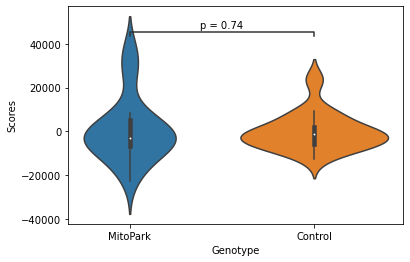

In [178]:
fig,ax = plt.subplots(1)
order = ['MitoPark', 'Control']
v3 = sns.violinplot(x = "Genotype", y = "Scores",ax = ax, data =df)

add_stat_annotation(ax, data=df, x = "Genotype", y = "Scores", order=order,
                    box_pairs=[("MitoPark", "Control")],
                    test='Mann-Whitney', text_format='simple', loc='inside', verbose=2)

array(['Control', 'Control', 'Control', 'Control', 'Control', 'Control',
       'Control', 'Control', 'Control', 'Control', 'Control', 'Control',
       'Control', 'Control', 'Control', 'Control', 'Control', 'Control',
       'Control', 'Control', 'Control', 'Control', 'Control', 'Control',
       'Control', 'Control', 'Control', 'Control', 'Control', 'Control'],
      dtype='<U7')

In [100]:
step_seconds

,Mouse,Video,Start Time,End Time,Genotype,FPS,Include,h5
0,1057,1057-2,02:49.8,02:50.1,MitoPark,100,True,C:\\Users\\ameet\\Box Sync\\BevanLab\\DLC_MP_t...
1,1057,1057-2,02:50.1,02:50.5,MitoPark,100,True,C:\\Users\\ameet\\Box Sync\\BevanLab\\DLC_MP_t...
2,1057,1057-2,03:31.7,03:31.9,MitoPark,100,True,C:\\Users\\ameet\\Box Sync\\BevanLab\\DLC_MP_t...
3,1057,1057-2,03:31.9,03:32.2,MitoPark,100,True,C:\\Users\\ameet\\Box Sync\\BevanLab\\DLC_MP_t...
4,1057,1057-2,03:32.2,03:32.5,MitoPark,100,True,C:\\Users\\ameet\\Box Sync\\BevanLab\\DLC_MP_t...
5,1057,1057-2,03:33.5,03:33.8,MitoPark,100,True,C:\\Users\\ameet\\Box Sync\\BevanLab\\DLC_MP_t...
6,1057,1057-2,03:33.8,03:34.0,MitoPark,100,True,C:\\Users\\ameet\\Box Sync\\BevanLab\\DLC_MP_t...
7,1057,1057-2,03:37.9,03:38.1,MitoPark,100,True,C:\\Users\\ameet\\Box Sync\\BevanLab\\DLC_MP_t...
8,1057,1057-2,03:38.1,03:38.3,MitoPark,100,True,C:\\Users\\ameet\\Box Sync\\BevanLab\\DLC_MP_t...
9,1057,1057-2,03:38.3,03:38.6,MitoPark,100,True,C:\\Users\\ameet\\Box Sync\\BevanLab\\DLC_MP_t...


THis should help with PCA score shit. https://www.sartorius.com/en/knowledge/science-snippets/what-is-principal-component-analysis-pca-and-how-it-is-used-507186 - basically, take each data vector, project it along each PC (for all 50). The coordinate value for each of these data points is the score, so we should have num_data amount of 50-length vectors. 
